# Neural network

### Try to use our own preprocessing

In [350]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA
import warnings
from pathlib import Path

from utils.data_processing import create_feables
from utils.data_processing import confusion_matrix

warnings.simplefilter("ignore")

# You should run the ../../data_preprocessing.ipynb notebook to generate the data before running this
data = pd.read_csv("../../datasets/data2.csv")
data = data.tail(1000)


# league_cols = [col for col in data.columns if 'League_' in col]
# print(league_cols)
# data = data.drop(league_cols, axis=1)
# data = data.tail(3000)

labels = data.loc[:,'label']
features = data.drop('label', axis = 1)

In [351]:
from sklearn.model_selection import train_test_split
#Splitting the data into train, test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 42, shuffle = True, stratify = labels)

# Show some rows of the data
X_train.head()

,Unnamed: 0,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won,games_against_lost,games_draw_home_team,games_draw_away_team,League_1.0,...,League_17642.0,League_19694.0,League_21518.0,League_24558.0,B365_Win,B365_Draw,B365_Defeat,BW_Win,BW_Draw,BW_Defeat
18892,19415,-9.0,-16.0,9.0,3.0,5.0,0.0,3.0,6.0,0,...,0,0,1,0,0.235763,0.304211,0.460026,0.239282,0.316338,0.444380
19533,20056,6.0,50.0,10.0,17.0,0.0,5.0,6.0,3.0,0,...,0,0,1,0,0.110987,0.179694,0.709318,0.106701,0.196555,0.696744
19254,19777,2.0,4.0,8.0,7.0,1.0,2.0,6.0,9.0,0,...,0,0,1,0,0.570939,0.238367,0.190694,0.560216,0.247070,0.192714
18847,19370,43.0,-16.0,15.0,6.0,5.0,0.0,3.0,3.0,0,...,0,0,1,0,0.903990,0.063279,0.032731,0.889912,0.077867,0.032221
19636,20159,37.0,1.0,16.0,1.0,0.0,0.0,2.0,0.0,0,...,0,0,1,0,0.877408,0.086146,0.036446,0.872077,0.082658,0.045265


In [352]:
# print(y_test)
print("Number of wins in test set:", np.sum(y_test == 2))
print("Number of draws in test set:", np.sum(y_test == 1))
print("Number of defeats in test set:", np.sum(y_test == 0))

Number of wins in test set: 116
Number of draws in test set: 62
Number of defeats in test set: 72


In [353]:
# Match outcome
y_train.head()

# Number of possible outcomes
# 2 = win
# 1 = draw
# 0 = lose
print('Number of possible outcomes', np.unique(y_train.values).shape[0])
labels = np.unique(y_train.values)
print("Labels:", labels)


Number of possible outcomes 3
Labels: [0. 1. 2.]


In [354]:
# Get number of columns by getting the number of columns in the X_train
columns = X_train.shape[1]
print('Number of columns:', columns)

Number of columns: 26


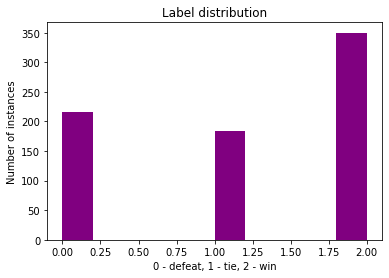

In [355]:
import matplotlib.pyplot as plt

# Plot the distribution of labels in the train data
def plot_labels_histogram(data):
    plt.hist(data, facecolor='purple', align='mid')
    plt.ylabel('Number of instances')
    plt.xlabel('0 - defeat, 1 - tie, 2 - win')
    plt.title("Label distribution")
    
plot_labels_histogram(y_train)

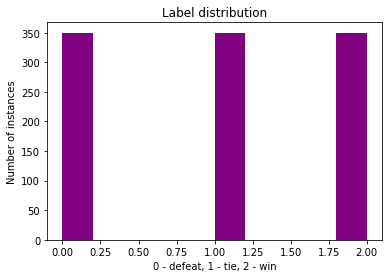

In [356]:
from imblearn.over_sampling import RandomOverSampler

# Since the train data is uneven and the dataset is not "huge" we need to upsamle/oversample
sampler = RandomOverSampler()
X_train_sampled, y_train_sampled = sampler.fit_sample(X_train, y_train)

# Plot the oversampled train set
plot_labels_histogram(y_train_sampled)

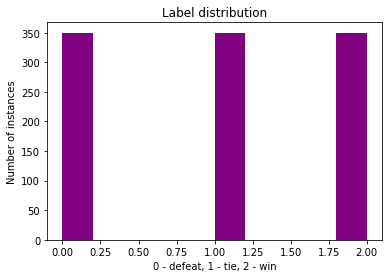

In [357]:
from sklearn.utils import shuffle

# Assign train values with the new sampled data
X_train, y_train = shuffle(X_train_sampled, y_train_sampled, random_state=42)

plot_labels_histogram(y_train)

In [358]:
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Flatten, Dense, Dropout
from keras.optimizers import SGD, Adam
from keras import regularizers

model = Sequential() 
model.add(Dense(40, input_dim=columns, activation='relu', kernel_regularizer='l2'))
#model.add(Dropout(0.1))
model.add(Dense(20, activation='relu', kernel_regularizer='l2'))
model.add(Dense(16, activation='relu', kernel_regularizer='l2'))
#model.add(Dropout(0.1))
model.add(Dense(8, activation='relu', kernel_regularizer='l2'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_202 (Dense)            (None, 40)                1080      
_________________________________________________________________
dense_203 (Dense)            (None, 20)                820       
_________________________________________________________________
dense_204 (Dense)            (None, 16)                336       
_________________________________________________________________
dense_205 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_206 (Dense)            (None, 3)                 27        
Total params: 2,399
Trainable params: 2,399
Non-trainable params: 0
_________________________________________________________________


In [359]:
from keras.utils.np_utils import to_categorical

# Convert a class vector (integers) to binary class matrix.
print("Label: \n", y_train.iloc[0])
print("Unique labels in the train set: ", np.unique(y_train))
# One hot encoding
y_train_categorical = to_categorical(y_train, num_classes=len(labels))
print("Unique labels in the train set after encoding: ", np.unique(y_train_categorical, axis=0))
# print("In categorical form: \n", y_train_categorical[0])

print("Number of wins in test set:", np.sum(y_train == 2))
print("Number of draws in test set:", np.sum(y_train == 1))
print("Number of defeats in test set:", np.sum(y_train == 0))

print("------------------------------------------------------------------------------ \n")
history = model.fit(X_train, y_train_categorical, batch_size=32, epochs=100, validation_split=0.2)

Label: 
 2.0
Unique labels in the train set:  [0. 1. 2.]
Unique labels in the train set after encoding:  [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
Number of wins in test set: 350
Number of draws in test set: 350
Number of defeats in test set: 350
------------------------------------------------------------------------------ 

Train on 840 samples, validate on 210 samples
Epoch 1/100
840/840 [==============================] - 5s 6ms/step - loss: 11.5218 - acc: 0.3381 - val_loss: 11.9044 - val_acc: 0.3143
Epoch 2/100
840/840 [==============================] - 0s 133us/step - loss: 11.5197 - acc: 0.3381 - val_loss: 11.9024 - val_acc: 0.3143
Epoch 3/100
840/840 [==============================] - 0s 130us/step - loss: 11.5177 - acc: 0.3381 - val_loss: 11.9003 - val_acc: 0.3143
Epoch 4/100
840/840 [==============================] - 0s 120us/step - loss: 11.5156 - acc: 0.3381 - val_loss: 11.8983 - val_acc: 0.3143
Epoch 5/100
840/840 [==============================] - 0s 110us/step - loss: 11.5136 

840/840 [==============================] - 0s 126us/step - loss: 11.4143 - acc: 0.3381 - val_loss: 11.7971 - val_acc: 0.3143
Epoch 58/100
840/840 [==============================] - 0s 108us/step - loss: 11.4125 - acc: 0.3381 - val_loss: 11.7953 - val_acc: 0.3143
Epoch 59/100
840/840 [==============================] - 0s 116us/step - loss: 11.4107 - acc: 0.3381 - val_loss: 11.7935 - val_acc: 0.3143
Epoch 60/100
840/840 [==============================] - 0s 126us/step - loss: 11.4089 - acc: 0.3381 - val_loss: 11.7917 - val_acc: 0.3143
Epoch 61/100
840/840 [==============================] - 0s 115us/step - loss: 11.4071 - acc: 0.3381 - val_loss: 11.7899 - val_acc: 0.3143
Epoch 62/100
840/840 [==============================] - 0s 112us/step - loss: 11.4053 - acc: 0.3381 - val_loss: 11.7881 - val_acc: 0.3143
Epoch 63/100
840/840 [==============================] - 0s 109us/step - loss: 11.4035 - acc: 0.3381 - val_loss: 11.7864 - val_acc: 0.3143
Epoch 64/100
840/840 [=========================

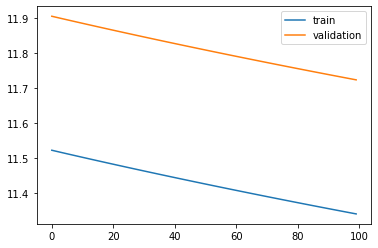

In [361]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

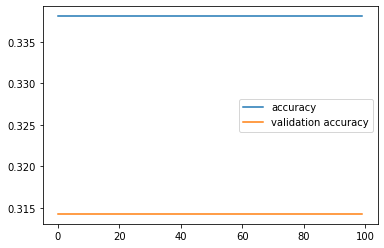

In [362]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

In [363]:
# Take the most probable prediction
# print(model.predict(X_test))
predictions = np.argmax(model.predict(X_test), axis=1)
print(np.unique(predictions))
# Calculate accuracy
accuracy = (predictions == y_test).mean()
print("Test set accuracy:", accuracy)

[1]
Test set accuracy: 0.248


# Let us plot the confusion matrix

0
[0]
Neural network confusion matrix: 
                    Home wins (pred)  Draw (pred)  Home loses (pred)
Home wins (true)                  0            0               2237
Draw (true)                       0            0               1230
Home loses (true)                 0            0               1405

 True labels distribution: 



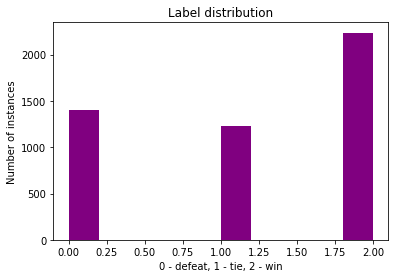

In [290]:
# from utils.data_processing import build_confusion_matrix

# TODO: Remove this and use the commented import instead
def build_confusion_matrix(y_true, y_pred):
    return pd.DataFrame(confusion_matrix(y_true, y_pred, labels=[2, 1, 0]),
                        index=['Home wins (true)', 'Draw (true)', 'Home loses (true)'],
                        columns=['Home wins (pred)', 'Draw (pred)', 'Home loses (pred)'])

print(np.sum((predictions == 1)))
print(np.unique(predictions))
print("Neural network confusion matrix: \n", build_confusion_matrix(y_test, predictions))


print('\n True labels distribution: \n')
plot_labels_histogram(y_test)

# Comparing Neural network to Random forest

In [ ]:
#Splitting the data into Train, Calibrate, and Test data sets
X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0, stratify = labels)
X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate, test_size = 0.25, random_state = 0, stratify = y_train_calibrate)


In [ ]:
from utils.data_processing import train_calibrate_predict

# Creating cross validation data splits
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)
cv_sets.get_n_splits(X_train, y_train)

# Init Random Forest
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')

#Specficying scorer and parameters for grid search
feature_len = features.shape[1]
scorer = make_scorer(accuracy_score)
parameters_RF = {'clf__max_features': ['auto', 'log2'], 'dm_reduce__n_components': np.arange(5, feature_len, int(np.around(feature_len/5)))}

#Initializing dimensionality reductions
pca = PCA()
RF_clf.fit(X_train, y_train)

print("Random forest accuracy for train set.".format(RF_clf.__class__.__name__, accuracy_score(y_train, RF_clf.predict(X_train))))
print("Random forest accuracy for test set".format(RF_clf.__class__.__name__, accuracy_score(y_test, RF_clf.predict(X_test))))

#Grid search, calibrate, and test the classifier
calibrated_RF_clf, dm_reduce, train_score, test_score = train_calibrate_predict(clf = RF_clf, dm_reduction = pca, X_train = X_train, y_train = y_train,
                                                                  X_calibrate = X_calibrate, y_calibrate = y_calibrate,
                                                                  X_test = X_test, y_test = y_test, cv_sets = cv_sets,
                                                                  params = parameters_RF, scorer = scorer, jobs = 1, use_grid_search = True)

In [ ]:
rf_predictions = RF_clf.predict(X_test)

# Calculate accuracy
accuracy = (rf_predictions == y_test).mean()
print("Random forest test set accuracy:", accuracy)

In [ ]:
print("Random forest confusion matrix: \n", build_confusion_matrix(y_test, rf_predictions))

# Conclusion